In [2]:
import os
import io
import pandas as pd
from minio import Minio
from datetime import date, timedelta, datetime


In [3]:
DEFAULT_ENDPOINT = "minio.fdi.ucm.es"
DEFAULT_BUCKET = "pd1"
def _client(access_key: str, secret_key: str, endpoint: str = DEFAULT_ENDPOINT) -> Minio:
    """Crear un cliente de MinIO"""
    return Minio(endpoint, access_key=access_key, secret_key=secret_key, secure=True)
def download_df_parquet(
    access_key: str,
    secret_key: str,
    object_name: str,
    endpoint: str = DEFAULT_ENDPOINT,
    bucket: str = DEFAULT_BUCKET
) -> pd.DataFrame:
    """Descargar un archivo parquet como pandas Dataframe"""
    c = _client(access_key, secret_key, endpoint)
    resp = c.get_object(bucket, object_name)
    try:
        data = resp.read()
    finally:
        resp.close()
        resp.release_conn()
    return pd.read_parquet(io.BytesIO(data))

def upload_df_parquet(
    access_key: str,
    secret_key: str,
    object_name: str,
    df: pd.DataFrame,
    endpoint: str = DEFAULT_ENDPOINT,
    bucket: str = DEFAULT_BUCKET
) -> None:
    """Subir un pandas Dataframe como objeto parquet"""
    c = _client(access_key, secret_key, endpoint)
    buf = io.BytesIO()
    df.to_parquet(buf, index=False)
    buf.seek(0)
    c.put_object(bucket, object_name, buf, length=buf.getbuffer().nbytes)

In [4]:
INPUT_CLIMATE_PATH = "grupo5/cleaned/clima_clean/date={day}/clima_{day}.parquet"
INPUT_GTFS_SCHEDULED_PATH = "grupo5/cleaned/gtfs_clean_scheduled/date={day}/gtfs_scheduled_{day}.parquet"
INPUT_GTFS_UNSCHEDULED_PATH = "grupo5/cleaned/gtfs_clean_unscheduled/date={day}/gtfs_unscheduled_{day}.parquet"
OUTPUT_CLIMATE_PATH ="grupo5/analytics/clima_clean/date={day}/clima_{day}.parquet"

In [5]:
def analisis(df_weather, df_gtfs_scheduled, df_gts_unscheduled):
    print(df_weather)
    print("-----------")
    print(df_gtfs_scheduled)
    print("-----------")
    print(df_gts_unscheduled)

In [6]:
def juntar(df_weather, df_gtfs_scheduled):
    df_weather["hour"] = df_weather.hour
    df_gtfs_scheduled["hour"] = df_gtfs_scheduled["actual_time"].str.split(':').str[0]
    df_unido_scheduled = pd.merge(df_weather, df_gtfs_scheduled, on="hour", how="inner")
    return df_unido_scheduled


In [7]:
def ejecucion(fechaini, fechafin):
    access_key = os.getenv("MINIO_ACCESS_KEY")
    secret_key = os.getenv("MINIO_SECRET_KEY")
    start_dt = datetime.strptime(fechaini, "%Y-%m-%d").date()
    end_dt = datetime.strptime(fechafin, "%Y-%m-%d").date()
    df_final = []
    curr = start_dt
    while curr <= end_dt:
        day = curr.strftime("%Y-%m-%d")
        try:
            # Descarga
            df_weather = download_df_parquet(access_key, secret_key, INPUT_CLIMATE_PATH.format(day=day))
            df_gtfs_scheduled = download_df_parquet(access_key, secret_key, INPUT_GTFS_SCHEDULED_PATH.format(day=day))
            df_gtfs_unscheduled = download_df_parquet(access_key, secret_key, INPUT_GTFS_UNSCHEDULED_PATH.format(day=day))
            df_dia = juntar(df_weather, df_gtfs_scheduled)
            # Analisis
            
            #analisis(df_weather, df_gtfs_scheduled, df_gtfs_unscheduled)
            df_final.append(df_dia)
            # Carga de datos 
            #upload_df_parquet(access_key, secret_key, OUTPUT_DATA_PATH.format(day=day), df_clean)
            
            print(f"{day}: Procesado correctamente.")
        except Exception as e:
            print(f"{day}: Error en transformación -> {str(e)}")
            
        curr += timedelta(days=1)
    df_maestro = pd.concat(df_final, ignore_index=True)
    return df_maestro

In [8]:
df_weather, df_gtfs_scheduled, df_gtfs_unscheduled = ejecucion("2025-01-02", "2025-01-02")


2025-01-02: Error en transformación -> You are trying to merge on int32 and object columns for key 'hour'. If you wish to proceed you should use pd.concat


ValueError: No objects to concatenate

In [ ]:
print(df_gtfs_scheduled.columns)
print(df_gtfs_scheduled["delay_seconds"])

Index(['trip_uid', 'match_key', 'route_id', 'stop_id', 'is_unscheduled',
       'scheduled_seconds', 'actual_seconds', 'delay_seconds', 'delay_minutes',
       'service_date', 'hour', 'hour_sin', 'hour_cos', 'dow', 'is_weekend',
       'scheduled_time', 'actual_time', 'lagged_delay_1', 'lagged_delay_2',
       'actual_headway_seconds', 'headway_ratio', 'route_rolling_delay',
       'period_of_day', 'is_peak', 'trip_progress', 'rolling_mean_delay_trip'],
      dtype='str')
0            NaN
1          -38.0
2          -22.0
3          -21.0
4           -4.0
           ...  
177088     -29.0
177089     -14.0
177090     -35.0
177091     -28.0
177092    2695.0
Name: delay_seconds, Length: 177093, dtype: float64


In [ ]:
df_weather

,Date,Temperature,Rain,Precipitation,Wind Speed,Snow,Cloud Cover,apparent_temp,precip_3h_accum,is_freezing,is_high_wind,hour,is_rush_hour
0,2025-01-02 00:00:00+00:00,6.60,0.0,0.0,47.873234,0.0,2.0,0.967283,0.0,0,0,0,0
1,2025-01-02 01:00:00+00:00,6.95,0.0,0.0,44.655239,0.0,0.0,1.619630,0.0,0,0,1,0
2,2025-01-02 02:00:00+00:00,6.65,0.0,0.0,48.380840,0.0,0.0,1.007782,0.0,0,0,2,0
3,2025-01-02 03:00:00+00:00,6.25,0.0,0.0,48.072128,0.0,0.0,0.481094,0.0,0,0,3,0
4,2025-01-02 04:00:00+00:00,5.95,0.0,0.0,48.112217,0.0,0.0,0.071372,0.0,0,0,4,0
5,2025-01-02 05:00:00+00:00,5.65,0.0,0.0,49.390244,0.0,0.0,-0.407468,0.0,0,0,5,0
6,2025-01-02 06:00:00+00:00,5.25,0.0,0.0,49.541546,0.0,0.0,-0.960550,0.0,0,0,6,0
7,2025-01-02 07:00:00+00:00,4.80,0.0,0.0,50.764153,0.0,1.0,-1.642467,0.0,0,1,7,1
8,2025-01-02 08:00:00+00:00,4.50,0.0,0.0,49.271690,0.0,2.0,-1.966304,0.0,0,0,8,1
9,2025-01-02 09:00:00+00:00,4.15,0.0,0.0,48.665287,0.0,21.0,-2.406815,0.0,0,0,9,1


In [ ]:
df_weather["hour"] = df_weather.hour
print(df_weather["hour"])
df_gtfs_scheduled["actual_time"] = pd.to_datetime(df_gtfs_scheduled["actual_time"])
print(df_gtfs_scheduled["actual_time"])
df_gtfs_scheduled["hour"] = df_gtfs_scheduled["actual_time"].dt.hour
print(df_gtfs_scheduled["hour"])

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: hour, dtype: int32


C:\Users\ivang\AppData\Local\Temp\ipykernel_20724\2571990230.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gtfs_scheduled["actual_time"] = pd.to_datetime(df_gtfs_scheduled["actual_time"])


0                        NaT
1        2026-02-28 05:01:52
2        2026-02-28 05:03:08
3        2026-02-28 05:04:39
4        2026-02-28 05:05:56
                 ...        
177088   2026-02-28 16:50:31
177089   2026-02-28 16:53:46
177090   2026-02-28 16:55:25
177091   2026-02-28 16:57:32
177092   2026-02-28 17:45:55
Name: actual_time, Length: 177093, dtype: datetime64[us]
0          NaN
1          5.0
2          5.0
3          5.0
4          5.0
          ... 
177088    16.0
177089    16.0
177090    16.0
177091    16.0
177092    17.0
Name: hour, Length: 177093, dtype: float64


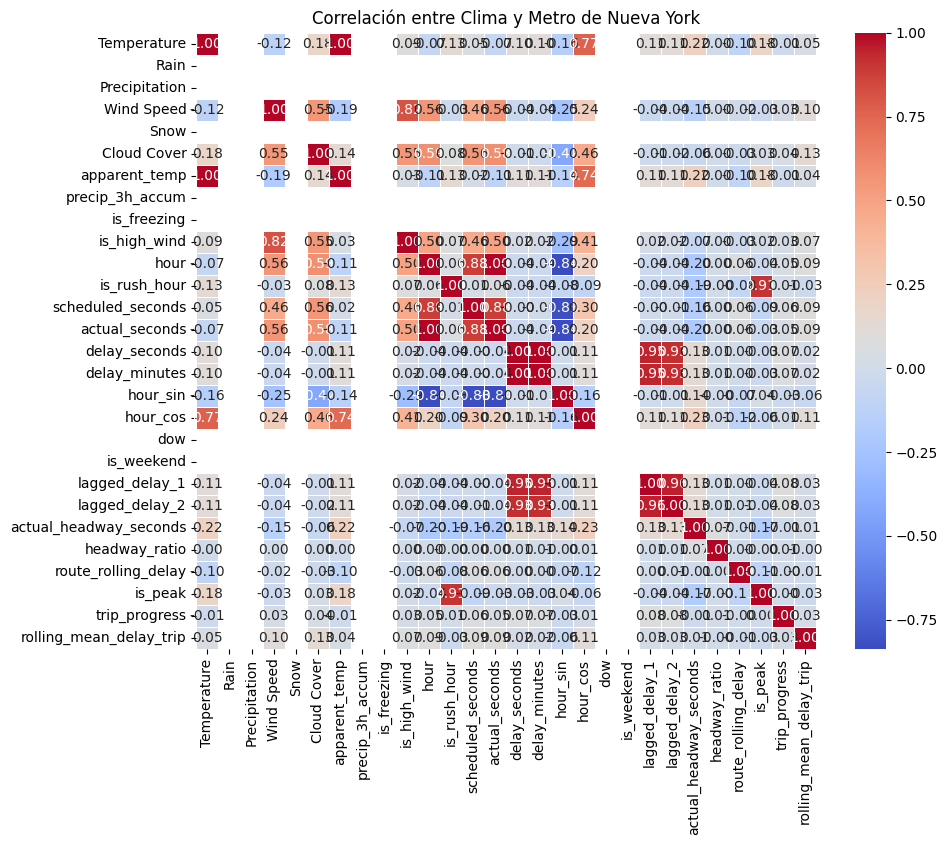

In [ ]:
df_unido_scheduled = pd.merge(df_weather, df_gtfs_scheduled, on="hour", how="inner")
# 1. Nos quedamos solo con las columnas que tienen números
df_numerico = df_unido_scheduled.select_dtypes(include=['number'])

# 2. Calculamos la matriz de correlación
matriz_correlacion = df_numerico.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor (heatmap)
sns.heatmap(matriz_correlacion, 
            annot=True,       # Muestra los números dentro de los cuadritos
            cmap='coolwarm',  # Colores: azul (negativo), rojo (positivo)
            fmt=".2f",        # Redondea a 2 decimales para que no se vea amontonado
            linewidths=0.5)

plt.title('Correlación entre Clima y Metro de Nueva York')
plt.show()

In [ ]:
df_maestro = ejecucion("2025-01-01", "2025-12-31")
df_numerico = df_maestro.select_dtypes(include=['number'])

# 2. Calculamos la matriz de correlación
matriz_correlacion = df_numerico.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor (heatmap)
sns.heatmap(matriz_correlacion, 
            annot=True,       # Muestra los números dentro de los cuadritos
            cmap='coolwarm',  # Colores: azul (negativo), rojo (positivo)
            fmt=".2f",        # Redondea a 2 decimales para que no se vea amontonado
            linewidths=0.5)

plt.title('Correlación entre Clima y Metro de Nueva York')
plt.show()

2025-01-01: Error en transformación -> You are trying to merge on int32 and object columns for key 'hour'. If you wish to proceed you should use pd.concat
2025-01-02: Error en transformación -> You are trying to merge on int32 and object columns for key 'hour'. If you wish to proceed you should use pd.concat
2025-01-03: Error en transformación -> You are trying to merge on int32 and object columns for key 'hour'. If you wish to proceed you should use pd.concat


KeyboardInterrupt: 

In [ ]:
def juntar(df_weather, df_gtfs_scheduled, day):
    df_weather = df_weather.dropna(subset=["hour"])
    df_gtfs_scheduled = df_gtfs_scheduled.dropna(subset=["actual_time"])
    
    # 1. Preparar la hora del clima
    df_weather["hour"] = df_weather["hour"].astype(int)
    
    # 2. Extraer la hora del metro
    # Le agregamos .astype(str) por si acaso algún dato raro se coló como número
    df_gtfs_scheduled["hour"] = df_gtfs_scheduled["actual_time"].astype(str).str.split(':').str[0].astype(int)
    
    # 3. EL RESUMEN (Agrupación)
    df_resumen_metro = df_gtfs_scheduled.groupby("hour").size().reset_index(name="cantidad_trenes_programados")
    
    # 4. Cruzar los datos
    df_unido = pd.merge(df_weather, df_resumen_metro, on="hour", how="inner")
    
    # 5. Estampar la fecha para el análisis anual
    df_unido["fecha"] = day
    
    return df_unido

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta

def ejecucion(fechaini, fechafin):
    access_key = os.getenv("MINIO_ACCESS_KEY")
    secret_key = os.getenv("MINIO_SECRET_KEY")
    start_dt = datetime.strptime(fechaini, "%Y-%m-%d").date()
    end_dt = datetime.strptime(fechafin, "%Y-%m-%d").date()
    
    # Le cambié el nombre a 'lista_diaria' porque es una lista, no un DataFrame todavía
    lista_diaria = [] 
    curr = start_dt
    
    while curr <= end_dt:
        day = curr.strftime("%Y-%m-%d")
        try:
            # 1. Extracción (Descarga)
            df_weather = download_df_parquet(access_key, secret_key, INPUT_CLIMATE_PATH.format(day=day))
            df_gtfs_scheduled = download_df_parquet(access_key, secret_key, INPUT_GTFS_SCHEDULED_PATH.format(day=day))
            df_gtfs_unscheduled = download_df_parquet(access_key, secret_key, INPUT_GTFS_UNSCHEDULED_PATH.format(day=day))
            
            # 2. Transformación 
            # ¡AQUÍ ESTÁ EL CAMBIO! Le pasamos la variable 'day' para estampar la fecha
            df_dia = juntar(df_weather, df_gtfs_scheduled, day)
            
            # Guardamos el pedacito procesado
            lista_diaria.append(df_dia)
            
            print(f"{day}: Procesado correctamente.")
            
        except Exception as e:
            # Excelente idea el try-except para que el pipeline no colapse
            print(f"{day}: Error en transformación -> {str(e)}")
            
        curr += timedelta(days=1)
        
    # 3. Consolidación Final
    # Solo concatenamos si la lista no está vacía (por si todos los días dieron error)
    if lista_diaria:
        df_maestro = pd.concat(lista_diaria, ignore_index=True)
        return df_maestro
    else:
        return pd.DataFrame() # Retorna un dataframe vacío si falló todo

2025-01-01: Procesado correctamente.
2025-01-02: Procesado correctamente.
2025-01-03: Procesado correctamente.
2025-01-04: Procesado correctamente.
2025-01-05: Procesado correctamente.
2025-01-06: Procesado correctamente.
2025-01-07: Procesado correctamente.
2025-01-08: Procesado correctamente.
2025-01-09: Procesado correctamente.
2025-01-10: Procesado correctamente.
2025-01-11: Procesado correctamente.
2025-01-12: Procesado correctamente.
2025-01-13: Procesado correctamente.
2025-01-14: Procesado correctamente.
2025-01-15: Procesado correctamente.
2025-01-16: Procesado correctamente.
2025-01-17: Procesado correctamente.
2025-01-18: Procesado correctamente.
2025-01-19: Procesado correctamente.
2025-01-20: Procesado correctamente.
2025-01-21: Procesado correctamente.
2025-01-22: Procesado correctamente.
2025-01-23: Procesado correctamente.
2025-01-24: Procesado correctamente.
2025-01-25: Procesado correctamente.
2025-01-26: Procesado correctamente.
2025-01-27: Procesado correctamente.
2

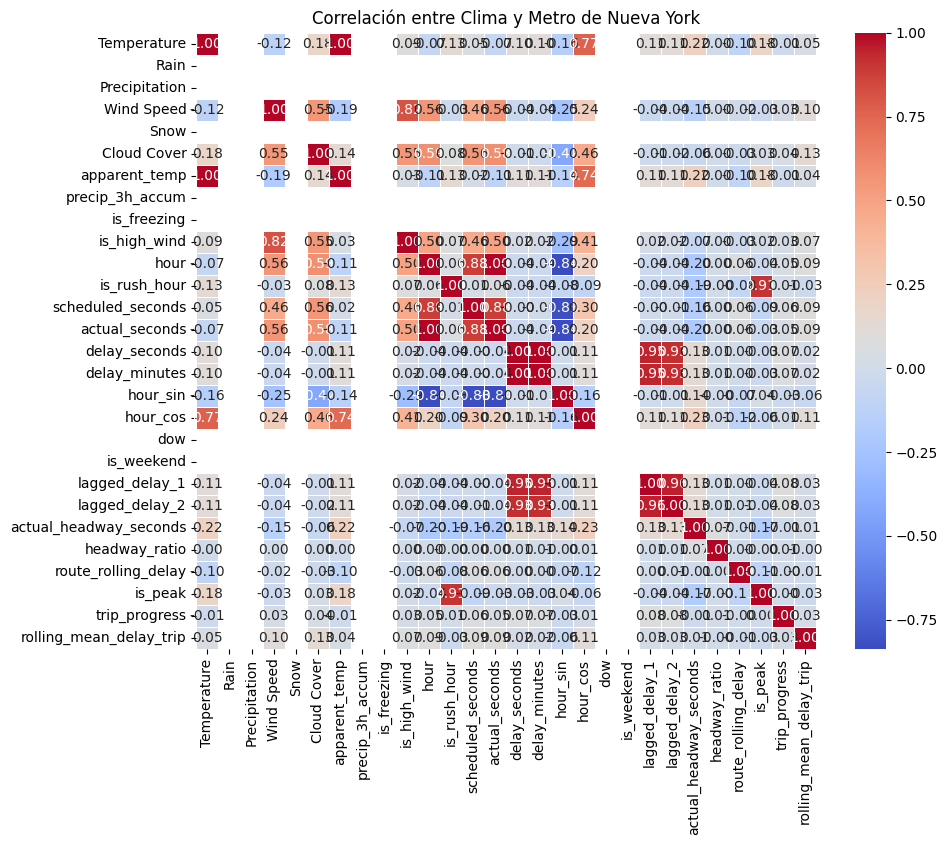

In [ ]:
df_maestro = ejecucion("2025-01-01", "2025-12-31")

# 2. Calculamos la matriz de correlación
matriz_correlacion = df_numerico.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor (heatmap)
sns.heatmap(matriz_correlacion, 
            annot=True,       # Muestra los números dentro de los cuadritos
            cmap='coolwarm',  # Colores: azul (negativo), rojo (positivo)
            fmt=".2f",        # Redondea a 2 decimales para que no se vea amontonado
            linewidths=0.5)

plt.title('Correlación entre Clima y Metro de Nueva York')
plt.show()

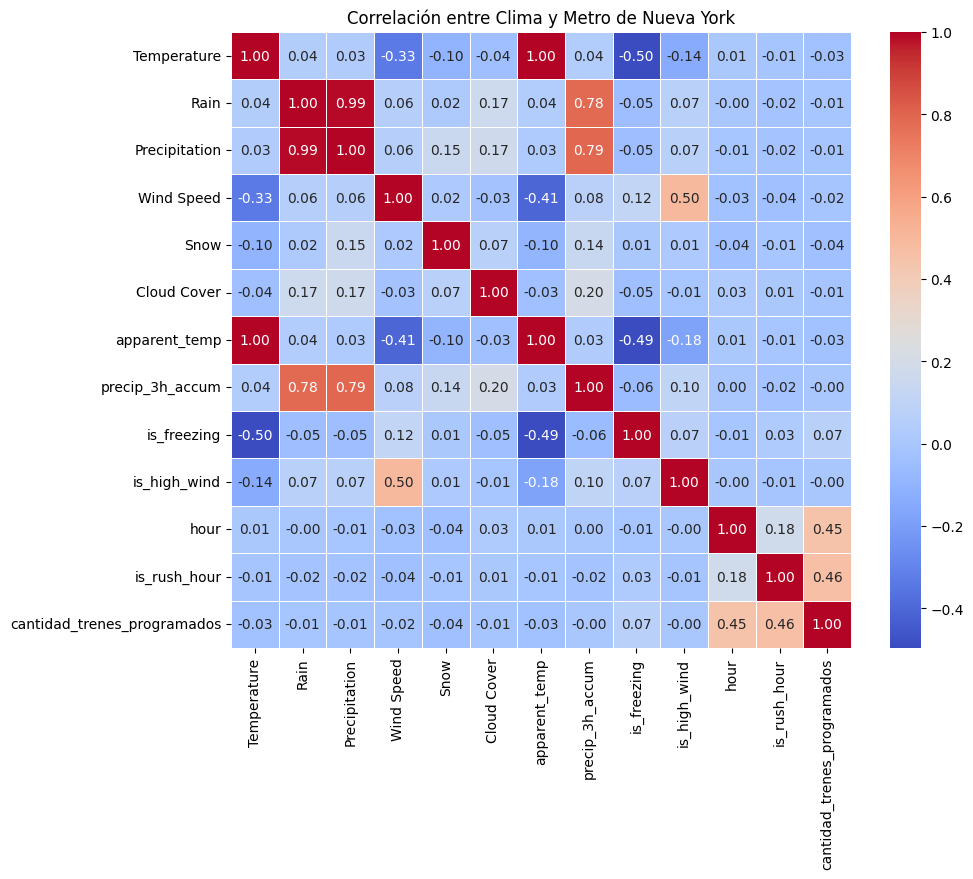

In [ ]:
df_numerico = df_maestro.select_dtypes(include=['number'])
# 2. Calculamos la matriz de correlación
matriz_correlacion = df_numerico.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor (heatmap)
sns.heatmap(matriz_correlacion, 
            annot=True,       # Muestra los números dentro de los cuadritos
            cmap='coolwarm',  # Colores: azul (negativo), rojo (positivo)
            fmt=".2f",        # Redondea a 2 decimales para que no se vea amontonado
            linewidths=0.5)

plt.title('Correlación entre Clima y Metro de Nueva York')
plt.show()